# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
feat_info.shape

(85, 4)

In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Total number of 'missing' or 'unknown' values to start.
azdias.isna().sum().sum()

4896838

In [10]:
# First, we need to convert the string object into a list, I am going to use a function for that.
def convert_string(string):
    ''' 
    Input = string object
    Output = list of 'unknown' or 'missing'
    '''
    new_list = []
    
    # takes the string object and splits it in ','
    string = string[1:-1].split(',')
    
    # for every value in the list, convert it into integer, if possible and append into new_list
    for i in string:
        try:
            new_list.append(int(i))
        except:
            new_list.append(i)
    return new_list

In [11]:
# Applying the function.
feat_info['NaN_tags'] = feat_info['missing_or_unknown'].apply(convert_string)

In [12]:
# Checking for correctness
feat_info.sample(5)

,attribute,information_level,type,missing_or_unknown,NaN_tags
34,SEMIO_DOM,person,ordinal,"[-1,9]","[-1, 9]"
39,SOHO_KZ,person,categorical,[-1],[-1]
41,VERS_TYP,person,categorical,[-1],[-1]
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
28,SEMIO_VERT,person,ordinal,"[-1,9]","[-1, 9]"


In [13]:
# Inserting NA into the dataframe
# Creating a copy of feat_info with the attributes as index, so we can use the .loc method
att_index = feat_info.set_index('attribute')

In [14]:
# Using np.NaN to replace the values with NaN
for col in azdias.columns:
    azdias[col].replace(att_index.loc[col].loc['NaN_tags'],np.NaN,inplace=True)


In [15]:
# Checking for the total NaN in the dataframe
azdias.isna().sum().sum()

8373929

There is an additional 3,477,838 NaN correctly labeled in the dataframe.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data = azdias.isna().sum()

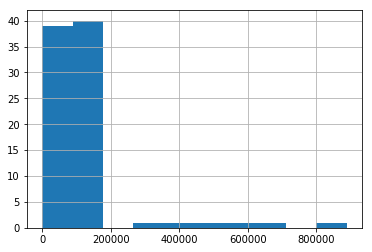

In [17]:
# Investigate patterns in the amount of missing data in each column.
missing_data.hist();


There are around 40 columns that are missing close to 200k data. Whats surprising is there are a handful that are missing more than half of the data if not almost all of the data!

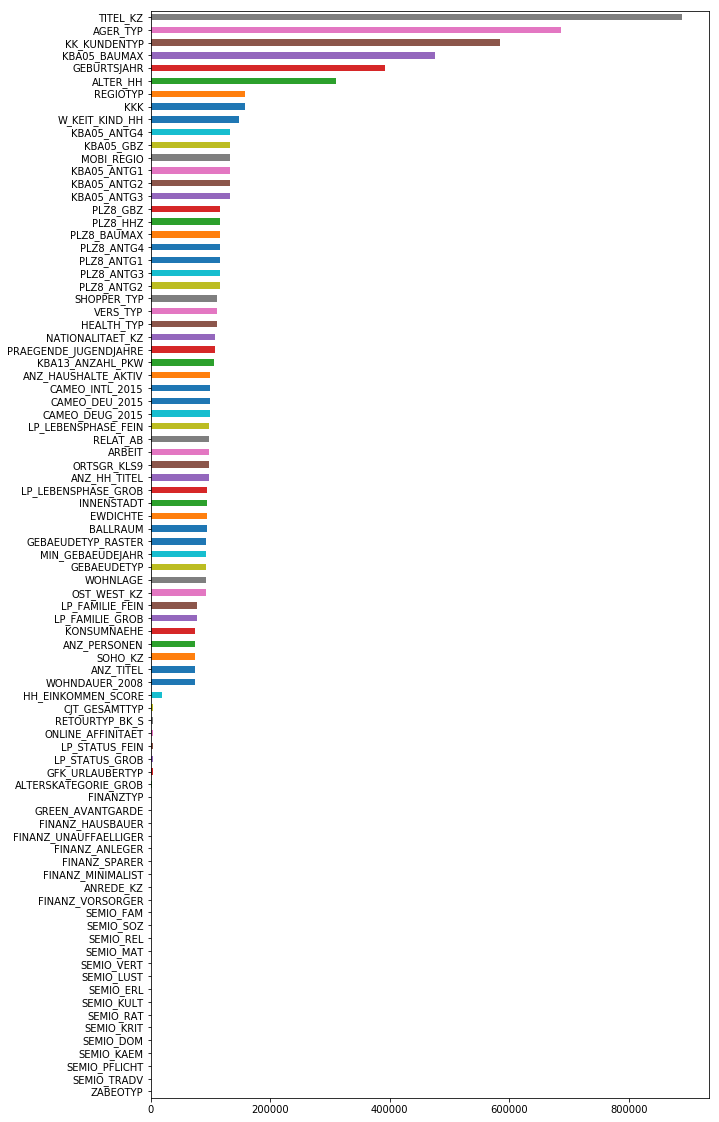

In [18]:
# Let's take a look at the columns with a lot of missing data.
missing_data.sort_values(inplace=True)
missing_data.plot.barh(figsize=(10,20));

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Based on the histogram above, I am going to drop the columns with missing values greater than 200k. 
dropped_columns = []
for col in azdias:
    if azdias[col].isna().sum() > 200000:
        dropped_columns.append(col)
        azdias.drop([col], axis=1, inplace=True)


In [20]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

The initial number of missing values is 4896838. After that we replaced the ones that are incorrectly entered with NaN. That gave us a total of 8373929 missing values. Next is I made a histogram of all missing values to see the distribution. Based on the histogram, I identified 200k as the threshold for outliers. After dropping the 6 columns that has more than 200k missing values, I am left with a dataframe of 79 columns. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

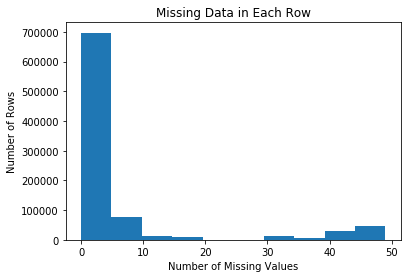

In [21]:
# How much data is missing in each row of the dataset?
missing_row = azdias.isnull().sum(axis=1)
plt.hist(missing_row)
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Missing Data in Each Row')
plt.show()

In [22]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
# Basing on the histogram above I am going to use 25 as the theshold.

azdias_above = azdias[azdias.isnull().sum(axis=1) > 25]
azdias_below = azdias[azdias.isnull().sum(axis=1) <= 25]

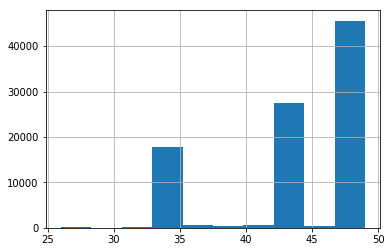

In [23]:
# Checking to see if most of the missing rows are above 25
azdias_above.isnull().sum(axis=1).hist();

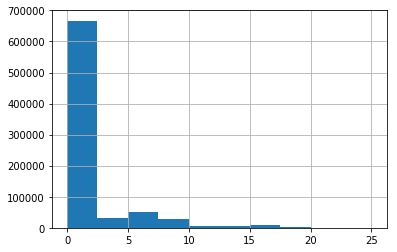

In [24]:
# Checking to see if most of the missing rows are below 25
azdias_below.isnull().sum(axis=1).hist()

In [25]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_distribution (df1, df2, column):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    graph_title = "Comparison of Column Distributions"
    fig.suptitle(graph_title, fontsize=16, verticalalignment='baseline')
    sns.countplot(df1[column], ax=ax1)
    sns.countplot(df2[column], ax=ax2)
    ax1.set_title('Below Threshold')
    ax2.set_title('Above Threshold')
    fig.show()


In [26]:
column_names = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER']

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


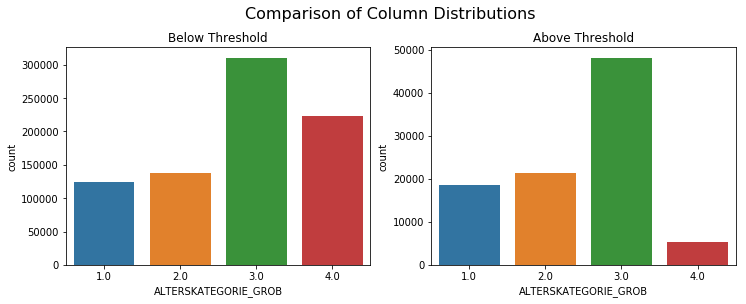

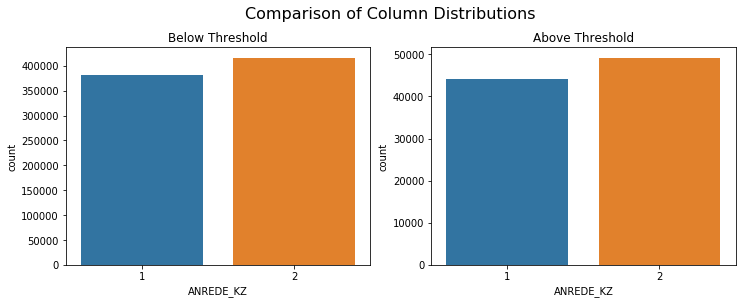

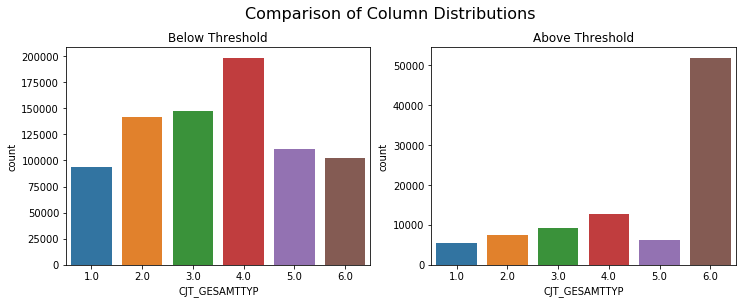

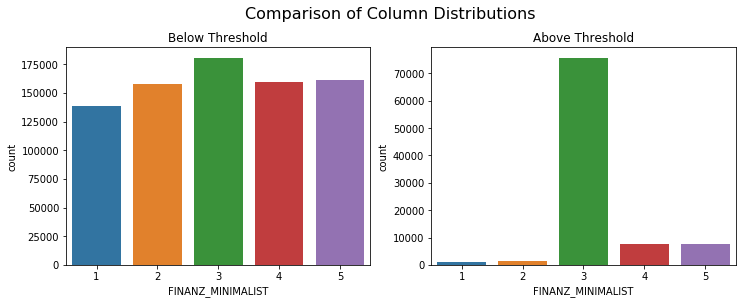

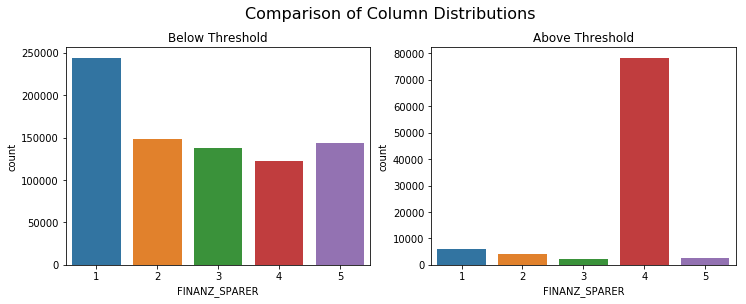

In [27]:
for col in column_names:
    compare_distribution(azdias_below, azdias_above, col)

#### Discussion 1.1.3: Assess Missing Data in Each Row
After assessing missing data in each column, I assessed missing data in each row next. I went and find the values then plot them on a histogram. By analyzing the histogram, I was able to make 2 subsets using a threshold roughly in the middle of the histogram. I compared the distributions of the two different subsets on same columns next. The distribution of the data that is above the threshold is not the same as the ones below the threshold. I don't know why is that the case, maybe user input is wrong or something else. I am choosing to not use the data that has missing values above the threshold as I would rather drop it than replace their input with the mean or mode or median. I believe that by doing so, I am risking skewing my model. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?
# Before answering that, I need to drop the dropped columns from feat_info

feat_info_new = feat_info.set_index('attribute').drop(dropped_columns).reset_index()

In [29]:
feat_info_new.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info_new[feat_info_new['type'] == 'categorical']
cat_var = categorical['attribute'].values.tolist()

In [31]:
cat_var

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [32]:
binary = []
multi = []

for cat in cat_var:
    if cat in azdias_below:
        if azdias_below[cat].nunique() == 2:
            binary.append(cat)
        else:
            multi.append(cat)
        


In [33]:
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [34]:
multi

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [35]:
for cat in binary:
    val = azdias_below[cat].value_counts()
    print(val)

2    416117
1    381844
Name: ANREDE_KZ, dtype: int64
0    622741
1    175220
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791245
1.0      6716
Name: SOHO_KZ, dtype: int64
2.0    394229
1.0    367052
Name: VERS_TYP, dtype: int64
W    629433
O    168528
Name: OST_WEST_KZ, dtype: int64


The columns OST_WEST_KZ takes W, O instead of numeric, therefore it has to be encoded.

In [36]:
for cat in multi:
    val = azdias_below[cat].value_counts()
    print(val)

4.0    198286
3.0    147208
2.0    141263
5.0    111107
6.0    102077
1.0     93307
Name: CJT_GESAMTTYP, dtype: int64
6    289059
1    197125
5    106326
2    104758
4     55916
3     44777
Name: FINANZTYP, dtype: int64
12.0    130241
10.0    102827
8.0      83029
11.0     75100
5.0      70499
4.0      60422
9.0      57125
3.0      53101
1.0      50656
2.0      43830
7.0      40679
6.0      25739
Name: GFK_URLAUBERTYP, dtype: int64
1.0     402539
10.0    128967
2.0      98551
11.0     48745
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    402539
5.0    188164
2.0     98551
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206853
9.0     136347
10.0    111574
2.0     111104
4.0      73969
3.0      68918
6.0      28894
5.0      27584
8.0      18801
7.0       9204
Name: LP_STATUS_FEIN, dtype: int64
1.0    317957
2.0    170471
4.0    155148
5.0    111574
3.0     38098
Na

In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.
col_list = ['OST_WEST_KZ']
azdias_below = pd.get_dummies(azdias_below, columns=col_list)


In [38]:
# I am dropping the multi-level categoricals to keep things straightforward
for col in multi:
    azdias_below.drop(col, axis=1, inplace=True)
    

In [39]:
azdias_below.shape

(797961, 67)

#### Discussion 1.2.1: Re-Encode Categorical Features

For this part, I selected the categorical columns from among them and split them into binary and multi-level. Binary columns are the columns that have only 2 unique values while multi-level takes more than that. Per project instructions, I kept the binary categoricals that take numeric values as is. The column OST_WEST_KZ takes 'W' and 'O' instead of 1 and 0 so I had to onehotencode that column as the models don't take non-numeric inputs. I also dropped all multi-level categoricals to keep it more straightforward. One downside of keeping all the multi-level categoricals is it will create a large number of dummy variables thus diluting the variability captured by components in PCA.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [40]:
# Identifying the mixed type variables
mixed = feat_info_new[feat_info_new['type'] == 'mixed']
mixed_var = mixed['attribute'].values.tolist()

In [41]:
mixed_var

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [42]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables(DECADE and MOVEMENT)
azdias_below['DECADE'] = azdias_below['PRAEGENDE_JUGENDJAHRE']
azdias_below['MOVEMENT'] = azdias_below['PRAEGENDE_JUGENDJAHRE']

In [43]:
# Dropping the original column
azdias_below.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [44]:
# I am defining a function to replace the movement, 0 = mainstream : 1 = avantgarde
# FYI all these values are referenced in Data_Dictionary.md file
def replace_movement(x):
    if x == 'NaN':
        return np.NaN
    elif x in [1,3,5,8,10,12,14]:
        return 0
    else:
        return 1

In [45]:
# Applying the function
azdias_below['MOVEMENT'] = azdias_below['MOVEMENT'].apply(replace_movement)

In [46]:
# Checking for accuracy
azdias_below['MOVEMENT'].value_counts()

0    594032
1    203929
Name: MOVEMENT, dtype: int64

In [47]:
# Function definition to convert ['DECADE'] into an interval type variable
def replace_decade(x):
    if x == 'NaN':
        return np.NaN
    elif x in [1,2]:
        return 40
    elif x in [3,4]:
        return 50
    elif x in [5,6,7]:
        return 60
    elif x in [8,9]:
        return 70
    elif x in [10,11,12,13]:
        return 80
    elif x in [14,15]:
        return 90

In [48]:
# Applying the function
azdias_below['DECADE'] = azdias_below['DECADE'].apply(replace_decade)

In [49]:
# Checking for accuracy
azdias_below['DECADE'].value_counts()

90.0    225511
70.0    175182
80.0    151761
60.0    114349
50.0     74292
40.0     28157
Name: DECADE, dtype: int64

In [50]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables(WEALTH and LIFESTAGE)
azdias_below['WEALTH'] = azdias_below['CAMEO_INTL_2015']
azdias_below['LIFESTAGE'] = azdias_below['CAMEO_INTL_2015']

In [51]:
# Dropping the original column
azdias_below.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [52]:
# Function definition to classify WEALTH according to data dictionary
# 1 = wealthy
# 2 = prosperous
# 3 = comfortable
# 4 = less affluent
# 5 = poorer

def replace_wealth(x):
    if pd.isnull(x):
        return np.NaN
    else:
        return int(str(x)[0])

In [53]:
# Applying the function
azdias_below['WEALTH'] = azdias_below['WEALTH'].apply(replace_wealth)

In [54]:
# Checking for accuracy
azdias_below['WEALTH'].value_counts()

5.0    223579
2.0    190674
4.0    189960
1.0    119438
3.0     68189
Name: WEALTH, dtype: int64

In [55]:
# Function definition to classify LIFESTAGE according to data dictionary
# 1 = Pre-family couples and singles
# 2 = Young couples with children
# 3 = Families with school age children
# 4 = Older families and mature couples
# 5 = Elders in retirement

def replace_lifestage(x):
    if pd.isnull(x):
        return np.NaN
    else:
        return int(str(x)[1])

In [56]:
# Applying the function
azdias_below['LIFESTAGE'] = azdias_below['LIFESTAGE'].apply(replace_lifestage)

In [57]:
# Checking for Accuracy
azdias_below['LIFESTAGE'].value_counts()

1.0    245049
4.0    232768
3.0    119687
5.0    117040
2.0     77296
Name: LIFESTAGE, dtype: int64

#### Discussion 1.2.2: Engineer Mixed-Type Features
I coded the two columns PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015 into 4 different columns. The data is sufficient enough that I was able to categorize them with what was given to me. I replaced their values with what they reflect using the data_dictionary.md file. I have decided to keep the rest and leave them as is, looking at the data_dictionary might prove useful. If at the end they don't mean anything then I might drop them later. 
 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [58]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_below.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797961 entries, 1 to 891220
Data columns (total 69 columns):
ALTERSKATEGORIE_GROB     795160 non-null float64
ANREDE_KZ                797961 non-null int64
FINANZ_MINIMALIST        797961 non-null int64
FINANZ_SPARER            797961 non-null int64
FINANZ_VORSORGER         797961 non-null int64
FINANZ_ANLEGER           797961 non-null int64
FINANZ_UNAUFFAELLIGER    797961 non-null int64
FINANZ_HAUSBAUER         797961 non-null int64
GREEN_AVANTGARDE         797961 non-null int64
HEALTH_TYP               761281 non-null float64
LP_LEBENSPHASE_FEIN      747828 non-null float64
LP_LEBENSPHASE_GROB      750714 non-null float64
RETOURTYP_BK_S           793248 non-null float64
SEMIO_SOZ                797961 non-null int64
SEMIO_FAM                797961 non-null int64
SEMIO_REL                797961 non-null int64
SEMIO_MAT                797961 non-null int64
SEMIO_VERT               797961 non-null int64
SEMIO_LUST               797961 n

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [97]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    
    feat_info['NaN_tags'] = feat_info['missing_or_unknown'].apply(convert_string)
    
    att_index = feat_info.set_index('attribute')
    
    for col in df.columns:
        df[col].replace(att_index.loc[col].loc['NaN_tags'],np.NaN,inplace=True)
           
    # remove selected columns
    dropped_columns = []
    for col in df:
        if df[col].isna().sum() > 200000:
            dropped_columns.append(col)
            df.drop([col], axis=1, inplace=True)
    
    # remove selected rows
    df_above = df[df.isnull().sum(axis=1) > 25]
    df_below = df[df.isnull().sum(axis=1) <= 25]

    # select, re-encode, and engineer column values.
    # identify the categorical columns
    categorical = feat_info_new[feat_info_new['type'] == 'categorical']
    cat_var = categorical['attribute'].values.tolist()

    # identify binary and multi
    binary = []
    multi = []

    for cat in cat_var:
        if cat in df_below:
            if df_below[cat].nunique() == 2:
                binary.append(cat)
            else:
                multi.append(cat)
    # encoding categorical and dropping the rest
    col_list = ['OST_WEST_KZ']
    df_below = pd.get_dummies(df_below, columns=col_list)
    
    for col in multi:
        df_below.drop(col, axis=1, inplace=True)

    # encoding mixed and dropping the unneeded columns
    mixed = feat_info_new[feat_info_new['type'] == 'mixed']
    mixed_var = mixed['attribute'].values.tolist()
    
    df_below['DECADE'] = df_below['PRAEGENDE_JUGENDJAHRE']
    df_below['MOVEMENT'] = df_below['PRAEGENDE_JUGENDJAHRE']
  
    df_below.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    df_below['MOVEMENT'] = df_below['MOVEMENT'].apply(replace_movement)
    df_below['DECADE'] = df_below['DECADE'].apply(replace_decade)
    
    df_below['WEALTH'] = df_below['CAMEO_INTL_2015']
    df_below['LIFESTAGE'] = df_below['CAMEO_INTL_2015']
    
    df['WEALTH'] = df_below['WEALTH'].apply(replace_wealth)
    df_below['LIFESTAGE'] = df_below['LIFESTAGE'].apply(replace_lifestage)
    
    df_below.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_below
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [60]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and # do that now.
# I am going to use impute to fill in the NaN
df_imp = Imputer(missing_values=np.NaN, strategy='median', axis=0)
azdias_clean = pd.DataFrame(df_imp.fit_transform(azdias_below))

In [61]:
azdias_clean.isna().sum().sum()

0

In [62]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_clean = pd.DataFrame(scaler.fit_transform(azdias_clean))


In [63]:
# Restoring columns and index
azdias_clean.columns = azdias_below.columns
azdias_clean.index = azdias_below.index


In [64]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,MOVEMENT,WEALTH,LIFESTAGE
1,-1.766616,0.957933,-1.494605,1.537983,-1.040689,1.466048,0.958818,1.339234,-0.530442,1.096551,...,0.574231,-0.166432,-0.127075,0.684853,-0.517442,0.517442,1.172911,-0.585915,1.186211,-1.266976
2,0.200529,0.957933,-1.494605,0.864617,-1.766963,-0.570958,0.244259,1.339234,1.885219,1.096551,...,0.574231,-0.166432,-0.127075,-0.789058,-0.517442,0.517442,1.172911,1.706732,-0.868182,0.761271
3,1.184102,0.957933,0.683156,-0.482116,1.138133,-0.570958,-1.184858,-0.791347,-0.530442,-0.257026,...,0.574231,-1.169962,-0.997594,-0.052103,-0.517442,0.517442,-0.223444,-0.585915,-1.552980,-0.590894
4,0.200529,-1.043914,0.683156,0.191250,0.411859,-1.249960,0.244259,-0.791347,-0.530442,1.096551,...,-0.337218,0.837098,0.308185,1.421808,-0.517442,0.517442,-0.223444,-0.585915,0.501413,0.085189
5,-1.766616,0.957933,-0.042764,-1.155482,1.138133,-0.570958,-0.470299,1.339234,-0.530442,1.096551,...,1.485680,-1.169962,-0.997594,-0.052103,-0.517442,0.517442,-1.619800,-0.585915,1.186211,0.761271


### Discussion 2.1: Apply Feature Scaling

I used sklearns impute to fill in the missing values. I used the median values in place of NaNs. After the missing values issue has been resolved, I fit the dataframe into the StandardScaler to normalize the dataset.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [65]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(azdias_clean)


In [66]:
# Investigate the variance accounted for by each principal component.
# function from the classroom's helper functions

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')



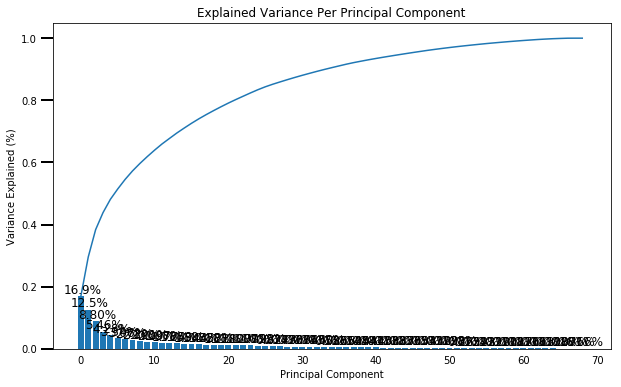

In [67]:
scree_plot(pca)

In [68]:
n_components = [20, 30, 35, 40, 50]
for n in n_components:
    pca = PCA(n)
    X_pca = pca.fit_transform(azdias_clean)
    if pca.explained_variance_ratio_.sum() >= .85:
        break

In [69]:
print(pca.n_components)

30


In [70]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=30)
X_pca = pca.fit_transform(azdias_clean)


In [71]:
pca.explained_variance_ratio_.sum()

0.87333598691817471

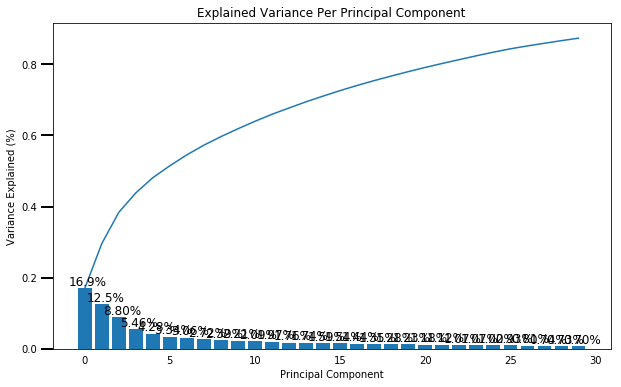

In [72]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction
After normalizing the dataset I then fit it on the PCA. What PCA does is reduce the dimensions of the data by filtering out noisy data, improving its interpretability while at the same time minimizing information loss. I could use the entire data for our model but its computationaly expensive. After the PCA, the results show that we can use just 30 while still retaining 87% accuracy.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [73]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def get_weights(df, n):
    components = pd.DataFrame(pca.components_,columns=list(df.columns)).iloc[n]
    top_5 = components.sort_values(ascending=False).head()
    bot_5 = components.sort_values(ascending=False).tail()
    comp = pd.concat([top_5, bot_5], axis=0, sort=True)
    comp.plot(kind='bar', title='Component ')
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()
    return comp

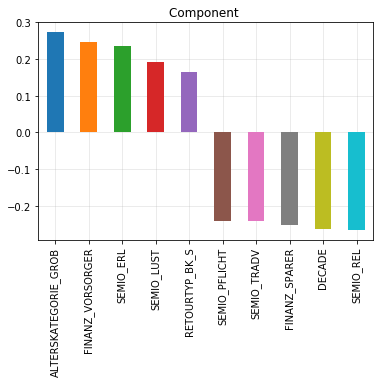

ALTERSKATEGORIE_GROB    0.272363
FINANZ_VORSORGER        0.244347
SEMIO_ERL               0.235592
SEMIO_LUST              0.191212
RETOURTYP_BK_S          0.164732
SEMIO_PFLICHT          -0.239908
SEMIO_TRADV            -0.240056
FINANZ_SPARER          -0.251995
DECADE                 -0.262249
SEMIO_REL              -0.264471
Name: 1, dtype: float64

In [74]:
get_weights(azdias_clean, 1)

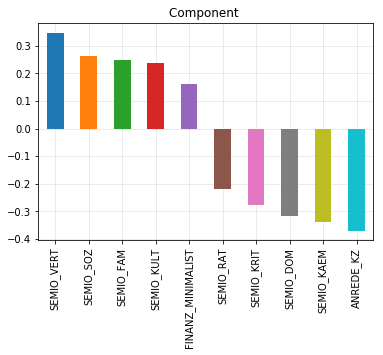

SEMIO_VERT           0.346976
SEMIO_SOZ            0.262238
SEMIO_FAM            0.250262
SEMIO_KULT           0.236237
FINANZ_MINIMALIST    0.161374
SEMIO_RAT           -0.217227
SEMIO_KRIT          -0.277855
SEMIO_DOM           -0.315280
SEMIO_KAEM          -0.339199
ANREDE_KZ           -0.369545
Name: 2, dtype: float64

In [75]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_weights(azdias_clean, 2)


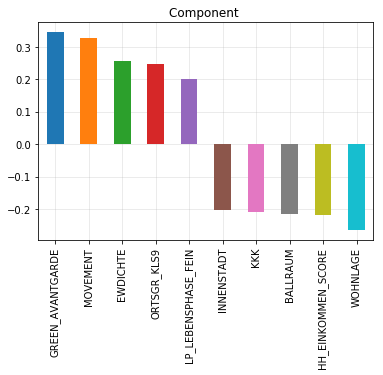

GREEN_AVANTGARDE       0.344631
MOVEMENT               0.328172
EWDICHTE               0.255839
ORTSGR_KLS9            0.246659
LP_LEBENSPHASE_FEIN    0.201574
INNENSTADT            -0.203283
KKK                   -0.207915
BALLRAUM              -0.216398
HH_EINKOMMEN_SCORE    -0.218342
WOHNLAGE              -0.264977
Name: 3, dtype: float64

In [76]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_weights(azdias_clean, 3)


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Observations from first principal component:
- The feature are shown to have a positive effect: 
        - age 
        - financial typology, like being prepared or I would say someone thatis not rich nor poor?
        - personality typology(event oriented, sensual oriented) 
        - shopping habits.
- The features are shown to have a negative effect:
        - have dutiful personality, traditional minded
        - money saver
        - age, older people
        - neighborhood quality
        
Observations from second principal component:
- These features are shown to have a positive effect:
        - people that have these personalities (dreamful, socially minded, family minded, cultural minded)
        - low financial interest, I guess the people that have no money?
- These features are shown to have a negative effect:
        - people that have these personalities (rational, critical minded, dominant minded, combative attitude)
        - gender
        
Observations from the third principal component:
- These features are shown to have a positive effect:
        - people that are in environmental sustainability of youth movement
        - density of household per sq.km.
        - size of the community
- These features are shown to have a negative effect:
        - distance to city center
        - purchasing power in the region
        - distance to nearest urban center
        - estimated household income
        - neighborhood quality.
        
To summarize the first principal component are comprised of features how an individual value their money and how it affects them. The second is mostly about an individual's personality and the third is mostly about the area of where the individual tends to skew their bias.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [77]:
# from the classroom's helper functions

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = MiniBatchKMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score


In [78]:
# Over a number of different cluster counts, run k-means clustering on the data and compute the average within-cluster distances.

center = [8, 10, 12, 14, 16]
score = []

for n in center:
    score.append(get_kmeans_score(X_pca,n))
    
    

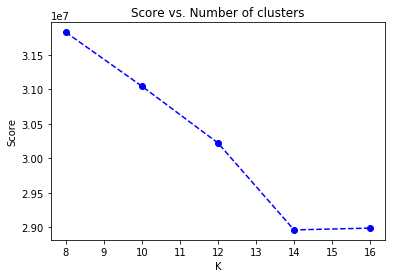

In [79]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(center, score, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Score');
plt.title('Score vs. Number of clusters');


In [80]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the general population demographics data.
# I am going to use 14 as the "elbow"
kmeans_14 = MiniBatchKMeans(n_clusters=14)
model_14 = kmeans_14.fit(X_pca)
model_preds = model_14.predict(X_pca)


### Discussion 3.1: Apply Clustering to General Population

After running the kmeans score, I determined to use 14 clusters for the model. As shown in the image above, increasing the cluster from 14 to 15 and above doesn't affect the kmeans score that much.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [98]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [99]:
customers_clean = clean_data(customers)

In [100]:
customers_clean.shape

(141642, 75)

In [104]:
# Since they have different shapes, there must be some columns in customers that are not in azdias_below, so we need to drop them
col = customers_clean.columns 
col_b = azdias_below.columns

In [111]:
missing_col = list(set(col) - set(col_b))
missing_col

['AGER_TYP',
 'ALTER_HH',
 'TITEL_KZ',
 'KK_KUNDENTYP',
 'GEBURTSJAHR',
 'KBA05_BAUMAX']

In [114]:
for col in missing_col:
    customers_clean.drop(col, axis=1, inplace=True)

In [115]:
customers_clean.shape

(141642, 69)

In [116]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,DECADE,MOVEMENT,WEALTH,LIFESTAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,5.0,1.0,2.0,1.0,0,1,50.0,1,13,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,2.0,3.0,5.0,3.0,0,1,50.0,1,34,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,4.0,1.0,3.0,1.0,0,1,40.0,0,24,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,3.0,3.0,5.0,1.0,0,1,70.0,0,41,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,5.0,3.0,7.0,5.0,0,1,50.0,1,34,4.0


In [117]:
customers_clean.isna().sum().sum()

123816

In [118]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Using impute
customers_imp = pd.DataFrame(df_imp.transform(customers_clean))

# Using scaler
customers_scaled = pd.DataFrame(scaler.transform(customers_imp))

In [119]:
# Restoring columns and index
customers_scaled.columns = customers_clean.columns
customers_scaled.index = customers_clean.index


In [120]:
# Applying the same PCA to customers data

customers_pca = pca.transform(customers_scaled)

In [121]:
# Clustering the customers
customers_preds = model_14.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [122]:
customers_preds = pd.DataFrame(customers_preds, columns=['C_Preds'])

In [123]:
model_preds = pd.DataFrame(model_preds, columns=['M_Preds'])

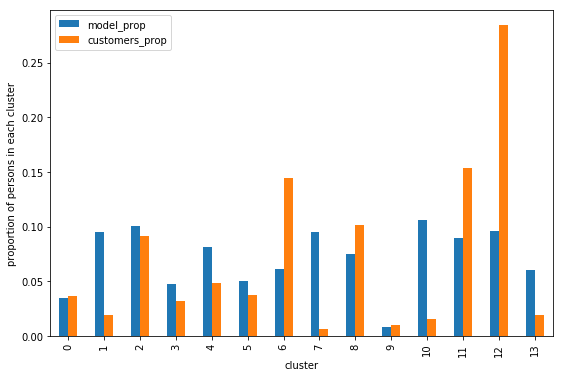

In [124]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

model_prop = []
customers_prop = []
x = [i for i in range(14)]
for i in range(14):
    customers_prop = customers_preds['C_Preds'].value_counts().sort_index()/ sum(customers_preds['C_Preds'].value_counts())
    model_prop = model_preds['M_Preds'].value_counts().sort_index()/ sum(model_preds['M_Preds'].value_counts())


df_props = pd.DataFrame({'cluster' : x, 'model_prop' : model_prop, 'customers_prop':customers_prop})
df_props.plot(x='cluster', y = ['model_prop', 'customers_prop'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()


In [167]:
# What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?
# I picked cluster 12 since customers_prop is greater than model_prop on that cluster
cluster12 = scaler.inverse_transform(pca.inverse_transform(kmeans_14.cluster_centers_[12])).round()
over_rep = pd.Series(data=cluster12, index=customers_clean.columns)
over_rep

ALTERSKATEGORIE_GROB       3.0
ANREDE_KZ                  1.0
FINANZ_MINIMALIST          3.0
FINANZ_SPARER              2.0
FINANZ_VORSORGER           4.0
FINANZ_ANLEGER             2.0
FINANZ_UNAUFFAELLIGER      2.0
FINANZ_HAUSBAUER           3.0
GREEN_AVANTGARDE           0.0
HEALTH_TYP                 2.0
LP_LEBENSPHASE_FEIN       13.0
LP_LEBENSPHASE_GROB        4.0
RETOURTYP_BK_S             4.0
SEMIO_SOZ                  5.0
SEMIO_FAM                  5.0
SEMIO_REL                  4.0
SEMIO_MAT                  4.0
SEMIO_VERT                 6.0
SEMIO_LUST                 5.0
SEMIO_ERL                  4.0
SEMIO_KULT                 5.0
SEMIO_RAT                  3.0
SEMIO_KRIT                 4.0
SEMIO_DOM                  3.0
SEMIO_KAEM                 3.0
SEMIO_PFLICHT              3.0
SEMIO_TRADV                3.0
SOHO_KZ                   -0.0
VERS_TYP                   2.0
ANZ_PERSONEN               1.0
                         ...  
KBA05_ANTG1                1.0
KBA05_AN

In [169]:
# What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?
# I picked cluster 7 since model_prop is greater than customer_prop on that cluster
cluster7 = scaler.inverse_transform(pca.inverse_transform(kmeans_14.cluster_centers_[7])).round()
under_rep = pd.Series(data=cluster7, index=customers_clean.columns)
under_rep


ALTERSKATEGORIE_GROB       2.0
ANREDE_KZ                  2.0
FINANZ_MINIMALIST          2.0
FINANZ_SPARER              4.0
FINANZ_VORSORGER           2.0
FINANZ_ANLEGER             5.0
FINANZ_UNAUFFAELLIGER      4.0
FINANZ_HAUSBAUER           3.0
GREEN_AVANTGARDE           0.0
HEALTH_TYP                 2.0
LP_LEBENSPHASE_FEIN       15.0
LP_LEBENSPHASE_GROB        5.0
RETOURTYP_BK_S             3.0
SEMIO_SOZ                  3.0
SEMIO_FAM                  4.0
SEMIO_REL                  5.0
SEMIO_MAT                  5.0
SEMIO_VERT                 2.0
SEMIO_LUST                 3.0
SEMIO_ERL                  4.0
SEMIO_KULT                 4.0
SEMIO_RAT                  6.0
SEMIO_KRIT                 5.0
SEMIO_DOM                  6.0
SEMIO_KAEM                 6.0
SEMIO_PFLICHT              6.0
SEMIO_TRADV                6.0
SOHO_KZ                    0.0
VERS_TYP                   1.0
ANZ_PERSONEN               2.0
                         ...  
KBA05_ANTG1                2.0
KBA05_AN

### Discussion 3.3: Compare Customer Data to Demographics Data

In this section I did the following steps:
- clean the customers dataset
- used impute on the cleand dataset
- scaled and transformed the dataset
- used .predict on the dataset.

Looking at the data, you can see that in clusters 6,11 and 12 are being overrepresented. Clusters 1,7 and 10 are being underrepresented. I investegated cluster 12 and 7 and checked what represents those group. For cluster 12, they are mainly born in the 60's, less afluent and belong to families with school age children, most of them are rational, single top earners of higher age. On the other hand cluster 7 is comprised of people born in the 80's, comfortable in life and belong to families with school age children, most of them are dreamful, low-income earner couples of higher age.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.